# Belgian Total Load 30-hours ahead forecasting
## Introduction

## Data preparation
We load a buch of libraries:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import sklearn
from sklearn.model_selection import KFold

The most important part of the used dataset if downloaded from _https://opendata.elia.be/explore/dataset/ods001/export/?sort=datetime_ . It contains measurements of the Belgian Total Load every 15 minutes, along with provided forecasts. We will consider, in this notebook, the _Most recent forecast_ as the baseline. This forecast (seems to be) made 30 hours before the time point it is linked to.

In [3]:
load = pd.read_csv("../data/preprocessed_data_18032025.csv", delimiter=',')
load["Datetime"] = pd.to_datetime(load["Datetime"], utc=True)
load["Datetime"] = load["Datetime"].dt.tz_convert('UTC') 
load

,Datetime,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Total Load Interpolated
0,2014-12-31 23:00:00+00:00,10142.19,9496.05,8871.71,10120.38,9697.59,9076.64,10318.53,9833.37,2014,12,31,23,0,3,0,10142.19
1,2014-12-31 23:15:00+00:00,10051.28,9329.17,8715.80,9942.53,9526.54,8916.55,10136.53,9653.31,2014,12,31,23,15,3,0,10051.28
2,2014-12-31 23:30:00+00:00,9952.87,9174.72,8571.51,9777.92,9367.66,8767.84,9967.47,9473.22,2014,12,31,23,30,3,0,9952.87
3,2014-12-31 23:45:00+00:00,9821.78,9025.46,8432.07,9618.85,9216.09,8625.97,9806.20,9319.45,2014,12,31,23,45,3,0,9821.78
4,2015-01-01 00:00:00+00:00,9755.00,9222.33,8880.23,9564.44,10130.36,9777.87,10482.86,9203.25,2015,1,1,0,0,0,0,9755.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358747,2025-03-25 21:45:00+00:00,NaN,9185.85,8769.06,9602.65,9185.85,8769.06,9602.65,9185.85,2025,3,25,21,45,0,0,10700.04
358748,2025-03-25 22:00:00+00:00,NaN,9069.36,8642.64,9496.08,9069.36,8642.64,9496.08,9069.36,2025,3,25,22,0,0,0,10700.04
358749,2025-03-25 22:15:00+00:00,NaN,8956.48,8535.07,9377.89,8956.48,8535.07,9377.89,8956.48,2025,3,25,22,15,0,0,10700.04
358750,2025-03-25 22:30:00+00:00,NaN,8861.24,8444.31,9278.17,8861.24,8444.31,9278.17,8861.24,2025,3,25,22,30,0,0,10700.04


Additionally, we download meteorological data from _https://opendata.meteo.be/download_, which allows us to get hourly measurements on the whole Belgian territory. Since the 15-minutes data from ELIA seems to interpolated between hourly-measured data, we will use the hourly measurement as a timestep.

In [5]:
weather = pd.read_csv("../webapp/backend/weather.csv")
weather["timestamp"] = pd.to_datetime(weather["timestamp"])
weather["timestamp"] = weather["timestamp"].dt.tz_localize('UTC')

Finally, from _https://opendata.elia.be/explore/dataset/ods047/export/_, we get information about the 15-minutes measurement of the system imbalance, that is (according to _https://www.emissions-euets.com/imbalances_) "_deviations between generation, consumption and commercial transactions of a balance responsible parties (BRPs) within a given imbalance settlement period._".

In [6]:
prices = pd.read_csv("../data/prices.csv", delimiter=';')
prices["DateTime"] = pd.to_datetime(prices["DateTime"], utc=True)
prices["DateTime"] = prices["DateTime"].dt.tz_convert('UTC') 

By inner-merging the load and the prices on the _Datetime_ columns, we keep the 15-minutes time granularity:

In [7]:
load_prices = pd.merge(load, prices, left_on='Datetime', right_on='DateTime', how='inner')

We only keep the following columns from the load/imbalance datasets:

In [8]:
keep_columns_load_prices = ['Datetime', 'Total Load', 'Most recent forecast', 'System imbalance']
load_prices = load_prices[keep_columns_load_prices]

Then, we preprocess the _weather_ data. First, we keep informations about the location of the measurement stations, the timestamp of each measure, the precipitations, temperatures, wind speed and pressure:

In [11]:
weather.columns

Index(['Unnamed: 0', 'timestamp', 'temperature', 'precipitation', 'wind',
       'pressure'],
      dtype='object')

In [9]:
keep_columns_weather = ['the_geom', 'timestamp', 'precip_quantity', 'temp_soil_avg', 'wind_speed_10m', 'pressure']
weather = weather[keep_columns_weather]

KeyError: "['the_geom', 'precip_quantity', 'temp_soil_avg', 'wind_speed_10m'] not in index"

Since the coordinates are geographical, we rename them with the closest city. This is purely informative, since, as we show later, we aggregate the local data by averaging them on the whole country. We only keep the local measurements where less than $500$ points are missing.

In [8]:
weather[['lat', 'lon']] = weather['the_geom'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
weather['location'] = (weather['lat'].astype(str) + '_' + weather['lon'].astype(str)).str.replace('.', '_')
weather['location'] = weather['location'].str.replace('49_62_5_587', 'Luxembourg')
weather['location'] = weather['location'].str.replace('50_511_6_073', 'Fagnes')
weather['location'] = weather['location'].str.replace('50_582_4_689', 'Gembloux')
weather['location'] = weather['location'].str.replace('50_797_4_358', 'Bruxelles')
weather['location'] = weather['location'].str.replace('50_916_5_45', 'Hasselt')
weather['location'] = weather['location'].str.replace('51_348_3_202', 'ZeeBruges')
weather['location'] = weather['location'].str.replace('50_194_5_255', 'Rochefort')
weather['location'] = weather['location'].str.replace('50_904_3_122', 'Courtrai')
weather['location'] = weather['location'].str.replace('50_096_4_595', 'Couvin')
weather['location'] = weather['location'].str.replace('50_98_3_816', 'Gand')
weather['location'] = weather['location'].str.replace('51_075_4_525', 'Malines')
weather['location'] = weather['location'].str.replace('51_325_4_364', 'Anvers')
weather['location'] = weather['location'].str.replace('51_221_5_027', 'Turnhout')
weather = weather.drop(['lat', 'lon', 'the_geom'], axis=1)

weather = weather.set_index(['timestamp', 'location']).unstack('location')
weather.columns = ['_'.join(col).strip() for col in weather.columns.values]
weather.reset_index(inplace=True)
keep_weather_stats = weather.isna().sum()<500
keep_weather_stats = keep_weather_stats[keep_weather_stats].index.tolist()
weather = weather[keep_weather_stats].ffill().bfill()

Finally, inner-merging the weather dataset with the load/imbalance on the Datetime column implicitely downsamples the load/imbalance data to 1-hour granularity.

In [9]:
full_data = pd.merge(load_prices, weather, left_on='Datetime', right_on='timestamp', how='inner').drop("timestamp", axis=1)

In order to complete the missing data, we perform a forward fill and a backward fill.

In [10]:
full_data = full_data.ffill().bfill()
full_data = full_data.iloc[::-1].reset_index(drop=True)

We add the target column, which is, for each timestep, the _Total Load_ value $30$ steps later. Since there will be meaningless missing data, we discard the $30$ last lines.

In [11]:
full_data["y"] = full_data["Total Load"].shift(-30)
full_data = full_data.iloc[:-30]

Finally, we extract the date informations from the Datetime column and we aggregate the local weather information.

In [12]:
full_data["Year"] = [i.year for i in full_data["Datetime"]]
full_data["Month"] = [i.month for i in full_data["Datetime"]]
full_data["Day"] = [i.day for i in full_data["Datetime"]]
full_data["Hour"] = [i.hour for i in full_data["Datetime"]]

full_data["Temperature"] = full_data[[i for i in full_data.columns if "temp_soil_avg" in i]].mean(axis=1)
full_data["Pressure"] = full_data[[i for i in full_data.columns if "pressure" in i]].mean(axis=1)
full_data["Wind"] = full_data[[i for i in full_data.columns if "wind" in i]].mean(axis=1)
full_data["Precipitation"] = full_data[[i for i in full_data.columns if "precip" in i]].mean(axis=1)

We save the generated dataset:

In [13]:
full_data.to_csv("dataset.csv")

## Modeling
The first part of the notebook can be avoided if the `dataset.csv` file has already been generated. We can load it:

In [14]:
data = pd.read_csv("dataset.csv", index_col=0)

### Persistence study
We can study how a simple persistent model would do. Of course, since we deal with data that might have periodicity, which previous timestep to make persist is an open question. We show that there are better timesteps to use:

In [15]:
rmse_by_lag = []

for t in tqdm(range(365*2*24)):
    shifted_total_load = data["Total Load"].shift(t)
    rmse_by_lag.append(np.sqrt(np.mean((data["y"]-shifted_total_load)**2)))

  0%|          | 0/17520 [00:00<?, ?it/s]

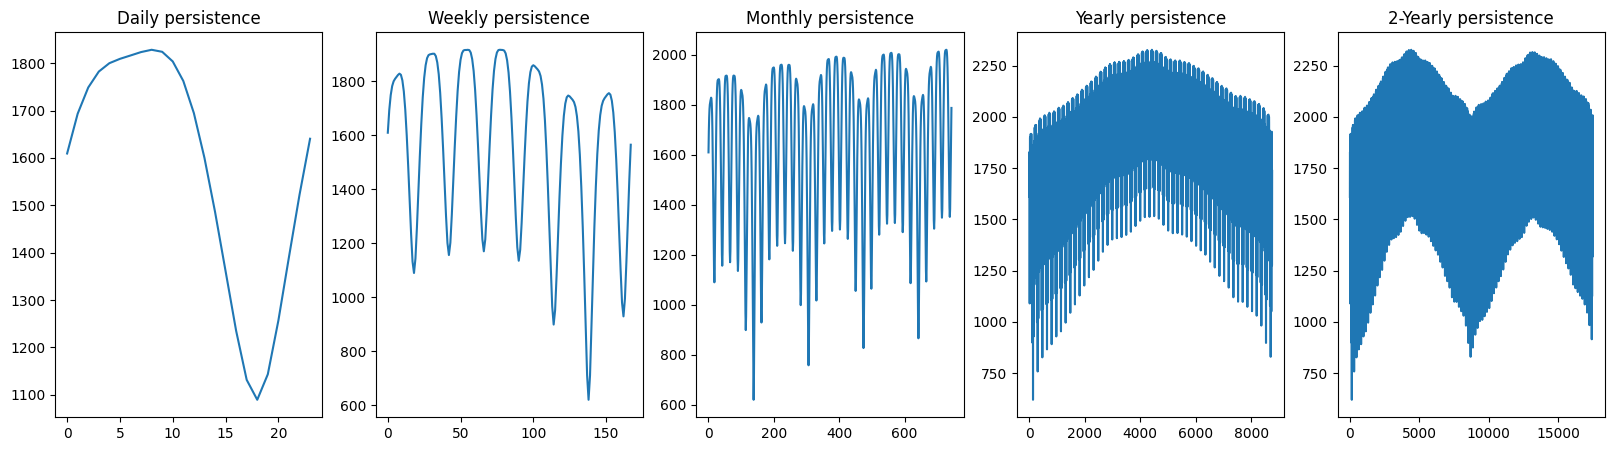

In [16]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].plot(rmse_by_lag[:24])
ax[0].set_title("Daily persistence")
ax[1].plot(rmse_by_lag[:24*7])
ax[1].set_title("Weekly persistence")
ax[2].plot(rmse_by_lag[:24*31])
ax[2].set_title("Monthly persistence")
ax[3].plot(rmse_by_lag[:24*365])
ax[3].set_title("Yearly persistence")
ax[4].plot(rmse_by_lag[:24*365*2])
ax[4].set_title("2-Yearly persistence")
plt.savefig("rmse_by_lag.png")
plt.show()

Which clearly shows that there is a daily, weekly and yearly cycle. The monthly cycle is way less clear. To be clearer: there are preferable lags to use if we want to use the persistent model, then there is an optimal previous timestep that we can output. We clearly see that the 1-week persistence is the best to use here (that is, outputting the Total Load one week before the forecasted point).

We can also see that there there is a monthly and yearly cycle. We decide therefore three things:
- We will use 1-month long measurements as input of the ML architecture (those contain the week-before FH and the month-before FH measurements)
- We will include the measurements made 1 year before (up to the FH) as input to the ML architecture
- We will use the 1-week before the FH measurement as a baseline that we will modify using a ML architecture

In [17]:
data["Total Load 1 Year Before, to the FH"] = data["Total Load"].shift(24 * 365 + 30)

data = data.iloc[365*24+30:]
data = data.reset_index()

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [19]:
GENERATING = True

### Inputs preparation
Our ML architecture will then take three inputs:
- The Load information: that is, 31*28 points of
    - The total load
    - The total load 1 year (+30hours) earlier
    - The system imbalance
- The meteo information, that is, 31*28 points of
    - The temperature
    - The precipitations
    - The wind speed
    - The pressure
- The persistent forecast, that is, the Total Load 1 week before the forecasted point

In [20]:
if GENERATING:
    X_load = []
    X_meteo = []
    X_baseline = []
    Y_elia = []
    Y = []
    
    t_features = 24*28
    features_load = ['Total Load',  'Total Load 1 Year Before, to the FH', 'System imbalance']
    features_meteo = ['Temperature', 'Precipitation', 'Wind', 'Pressure']
    features_baseline = ['Total Load']
    
    for start in tqdm(range(len(data) - t_features + 1 - 30)):
        X_load.append(data.iloc[start:start + t_features][features_load].values.T)
        X_meteo.append(data.iloc[start:start + t_features][features_meteo].values.T)
        X_baseline.append(data.iloc[start + t_features - 1 + 30 - 7 * 24][features_baseline].values.flatten())
        Y_elia.append(data.iloc[start + t_features - 1 + 30]['Most recent forecast'])
        Y.append(data.iloc[start + t_features - 1]['y'])
        
    X_load = torch.tensor(np.array(X_load, dtype=np.float32)).to(device)
    X_meteo = torch.tensor(np.array(X_meteo, dtype=np.float32)).to(device)
    X_baseline = torch.tensor(np.array(X_baseline, dtype=np.float32)).to(device)
    Y_elia = torch.tensor(np.array(Y_elia, dtype=np.float32)).to(device)
    Y = torch.tensor(np.array(Y, dtype=np.float32)).to(device)
    torch.save(X_load, "X_load.pt")
    torch.save(X_meteo, "X_meteo.pt")
    torch.save(X_baseline, "X_baseline.pt")
    torch.save(Y, "Y.pt")
else:
    X_load = torch.load("X_load.pt", weights_only=True).to(device)
    X_meteo = torch.load("X_meteo.pt", weights_only=True).to(device)
    X_baseline = torch.load("X_baseline.pt", weights_only=True).to(device)
    Y_elia = torch.load("Y_elia.pt", weights_only=True).to(device)
    Y = torch.load("Y.pt", weights_only=True).to(device)

  0%|          | 0/67567 [00:00<?, ?it/s]

### Model
Our model then consists in three parts:
- One CNN that extracts features from the load data
    - Output vector size: (16,)
- One CNN that extracts features from the weather data
    - Output vector size: (16,)
- One MLP that forecasts the 30-hours later Total Load, given
    - The persistent value
    - The two features vectors

In [21]:
class ConvFeatureExtractor(nn.Module):
    def __init__(self, mlp_size):
        super(ConvFeatureExtractor, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding="same")
        self.l1 = nn.Linear(mlp_size, 512)
        self.l2 = nn.Linear(512, 128)
        self.l3 = nn.Linear(128, 16)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.tanh(x)
        x = self.conv2(x)
        x = self.tanh(x.reshape((x.shape[0], -1)))
        x = self.tanh(self.l1(x))
        x = self.tanh(self.l2(x))
        x = self.l3(x)
        return x
            
class ForecastModel(nn.Module):
    def __init__(self):
        super(ForecastModel, self).__init__()
        self.feature_extractor_load = ConvFeatureExtractor(mlp_size=2016)
        self.feature_extractor_meteo = ConvFeatureExtractor(mlp_size=2688)
        self.l1 = nn.Linear(16*2, 1)
    
    def forward(self, x_load, x_meteo, x_baseline):
        x = self.l1(torch.concatenate([self.feature_extractor_load(x_load), self.feature_extractor_meteo(x_meteo)], axis=1))
        return (x + x_baseline).squeeze()

In order to correctly evaluate the performances of our model, we include in the dataset the `Most recent forecast` provided by ELIA, so that the cross-validation procedure assesses the quality of both our architecture and the ELIA baseline.

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_load, X_meteo, X_baseline, y_elia, y):
        self.X_load = X_load
        self.X_meteo = X_meteo
        self.X_baseline = X_baseline
        self.y_elia = y_elia
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_load[idx], self.X_meteo[idx], self.X_baseline[idx], self.y_elia[idx], self.y[idx]

We prepare a 5-fold cross-validation.

In [23]:
dataset = TimeSeriesDataset(X_load, X_meteo, X_baseline, Y_elia, Y)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Finally, we train and evaluate the model. The NN is trained for 30 epochs at each fold of the cross-validation.

In [24]:
torch.manual_seed(0)
batch_size = 32
val_losses = []
val_losses_elia = []
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    model = ForecastModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0002)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=5, threshold=3.)
    
    for epoch in (pbar:=tqdm(range(30))):
        model.train()
        losses = []
        for x_load, x_meteo, x_baseline, _, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_load, x_meteo, x_baseline)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item()**0.5)
        lr_scheduler.step(np.mean(losses[-30:]))
        
        model.eval()
        val_loss = []
        val_loss_elia = []
        with torch.no_grad():
            for x_load, x_meteo, x_baseline, y_elia, y in val_loader:
                if x_load.shape[0] == batch_size:
                    outputs = model(x_load, x_meteo, x_baseline)
                    val_loss.append(criterion(outputs, y).item()**0.5)
                    val_loss_elia.append(criterion(y_elia, y).item()**0.5)
        pbar.set_description(f"Loss: {np.mean(val_loss):.2f}, Loss ELIA: {np.mean(val_loss_elia):.2f}")
    val_losses.append(np.mean(val_loss))
    val_losses_elia.append(np.mean(val_loss_elia))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

As we can see, our architecture outperforms ELIA:

In [25]:
print("Losses ELIA:\t", val_losses_elia)
print("Losses NN:\t", val_losses)
print("Mean ELIA:\t", np.mean(val_losses_elia))
print("Mean NN:\t", np.mean(val_losses))

Losses ELIA:	 [217.98524940554768, 215.75221851331835, 218.7684333442405, 217.42466089778912, 220.107136726017]
Losses NN:	 [174.59740974985561, 171.6421827363733, 169.27532104263977, 192.34430837625243, 159.0641980836237]
Mean ELIA:	 218.00753977738253
Mean NN:	 173.38468399774897
